In [1]:
import numpy as np 
import cvxpy as cp

from itertools import combinations
from tqdm import tqdm

from scipy.linalg import fractional_matrix_power

from matplotlib import pyplot as plt

In [30]:
def RandomSheaf(V, d):
    # Let's generate a toy topology for our example

    p = 1.1 * np.log(V)/V
    edges = []
    for e in combinations(range(V),2):
        l = np.random.rand(1)
        if l < p:
            edges.append(e)

    F = {
        e:{
            e[0]:np.random.randn(d,d),
            e[1]:np.random.randn(d,d)
            } 
            for e in edges
        }                                           # Incidency linear maps

    # Sheaf representation 

    # Coboundary map

    B = np.zeros((d*len(edges), d*V))

    for i in range(len(edges)):
        edge = edges[i]

        u = edge[0] 
        v = edge[1] 

        B_u = F[edge][u]
        B_v = F[edge][v]

        B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f = B.T @ B
    return L_f, edges

In [31]:
L_f, edges = RandomSheaf(20,3)

In [3]:
'''
D = np.diag(np.diagonal(L_f))
L_f = fractional_matrix_power(D, -0.5) @ L_f @ fractional_matrix_power(D, -0.5)
'''

In [28]:
def RandomSheafSignal(N, V, d, L_f):
    X = np.random.randn(V*d,N)

    # Tikhonov regularization step
    Lambda, U = np.linalg.eig(L_f)
    H = 1/(1 + 10*Lambda)
    Y = U @ np.diag(H) @ U.T @ X

    return Y

In [29]:
Y = RandomSheafSignal(100, 20, 3, L_f)

In [7]:
L_f /= np.linalg.norm(L_f)

In [43]:
def MapSolver_it(
        d,
        F_u_k, 
        F_v_k, 
        Xu, 
        Xv, 
        beta_u, 
        beta_v, 
        tau):
    
    A11 = np.kron(Xu @ Xu.T, np.eye(d)) + beta_u * np.kron(np.eye(d), F_v_k @ F_v_k.T) + tau * np.eye(d**2)
    A12 = - np.kron(Xu @ Xv.T, np.eye(d))
    A21 = - np.kron(Xv @ Xu.T, np.eye(d))
    A22 = np.kron(Xv @ Xv.T, np.eye(d)) + beta_v * np.kron(np.eye(d), F_u_k @ F_u_k.T) + tau * np.eye(d**2)

    A = np.block([[A11, A12],
                  [A21, A22]])
    
    b = np.block([[(1 / (np.trace(- F_u_k @ F_u_k.T)) - tau) * F_u_k.flatten().reshape(-1,1)],
                  [(1 / (np.trace(- F_v_k @ F_v_k.T)) - tau) * F_v_k.flatten().reshape(-1,1)]])
    
    sol = np.linalg.solve(A,b)

    Fu = sol[0:d*d,:]
    Fv = sol[d*d:,:]

    return Fu.reshape(d,d), Fv.reshape(d,d)

In [47]:
def MapSolver(
        d,
        Xu, 
        Xv, 
        beta_u, 
        beta_v, 
        tau, 
        gamma = 0.99,
        MAX_ITER = 10,
        tol = 1e-5  # Tolerance for early stopping
):
    
    # Initialization 
    F_u = np.eye(d)
    F_v = np.eye(d)

    # Main loop
    for _ in range(MAX_ITER):
        F_u_hat, F_v_hat = MapSolver_it(    
            d,    
            F_u, 
            F_v, 
            Xu, 
            Xv, 
            beta_u, 
            beta_v, 
            tau)
        
        F_u_hat = np.real(F_u_hat)
        F_v_hat = np.real(F_v_hat)

        # Compute the norm of the update for early stopping
        delta_u = np.linalg.norm(F_u_hat - F_u)
        delta_v = np.linalg.norm(F_v_hat - F_v)

        # Early stopping condition
        if delta_u < tol and delta_v < tol:
            break

        # Iterate update
        F_u += gamma * (F_u_hat - F_u)
        F_v += gamma * (F_v_hat - F_v)

        # Stepsize update
        gamma *= (1 - 0.01 * gamma)       

    return F_u, F_v

In [48]:
def SheafSolver(
        Y, 
        V,
        d, 
        beta_u, 
        beta_v, 
        tau, 
        ):
    
    maps = {
        edge: {
            edge[0]:None,
            edge[1]:None
        } for edge in combinations(range(V), 2)
    }

    for e in tqdm(combinations(range(V),2)):
        u = e[0]
        v = e[1]

        Xu = Y[u*d:(u+1)*d,:]
        Xv = Y[v*d:(v+1)*d,:]

        Fu, Fv = MapSolver(        
            d,
            Xu, 
            Xv, 
            beta_u, 
            beta_v, 
            tau,
            gamma = 0.99,
            MAX_ITER = 100
            )

        maps[e][u] = Fu
        maps[e][v] = Fv

    return maps

In [ ]:
M = 10

V = 20
sim = {d_: np.zeros(M) for d_ in range(1,10)}
for d_ in tqdm(range(1,10)):
    for m in range(M):
        L_f, edges = RandomSheaf(V, d_)
        Y = RandomSheafSignal(100, V, d_, L_f)

        maps_ = SheafSolver(Y, V, d_, 1, 1, 1)

        E0 = len(edges)
        all_edges = list(combinations(range(V), 2))

        energies = {
            e : 0
            for e in all_edges
            }

        for e in all_edges:
            X_u = Y[d_*e[0]:(e[0]+1)*d_,:]
            X_v = Y[d_*e[1]:(e[1]+1)*d_,:]

            energies[e] = (
                np.linalg.norm(maps_[e][e[0]] @ X_u - maps_[e][e[1]] @ X_v))
        retrieved = sorted(energies.items(), key=lambda x:x[1])

        recall = len(set(list(map(lambda x: x[0], retrieved[:E0]))).intersection(set(edges[:E0]))) / E0

        edges_subset = list(set(list(map(lambda x: x[0], retrieved[:E0]))).intersection(set(edges[:E0])))

        sim[d_][m] = recall

  0%|          | 0/9 [00:00<?, ?it/s]
0it [00:00, ?it/s]

190it [00:15, 12.02it/s]
190it [00:15, 12.02it/s]
190it [00:15, 11.90it/s]


In [35]:
TVs = {E:None for E in range(len(list(combinations(range(V),2))))}

for E in range(len(list(combinations(range(V),2)))):
    B_hat_2 = np.zeros((d*E, d*V))

    for i, edge in enumerate([retrieved[i][0] for i in range(E)]):

        u = edge[0] 
        v = edge[1] 

        B_u = maps_[edge][u]
        B_v = maps_[edge][v]

        B_hat_2[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B_hat_2[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f_hat_2 = B_hat_2.T @ B_hat_2
    L_f_hat_2 /= np.linalg.norm(L_f_hat_2)

    TVs[E] = np.trace(Y.T @ L_f_hat_2 @ Y)


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_22612\2602925345.py:20: RuntimeWarning: invalid value encountered in divide
  L_f_hat_2 /= np.linalg.norm(L_f_hat_2)


In [36]:
TV = np.trace(Y.T @ L_f @ Y)

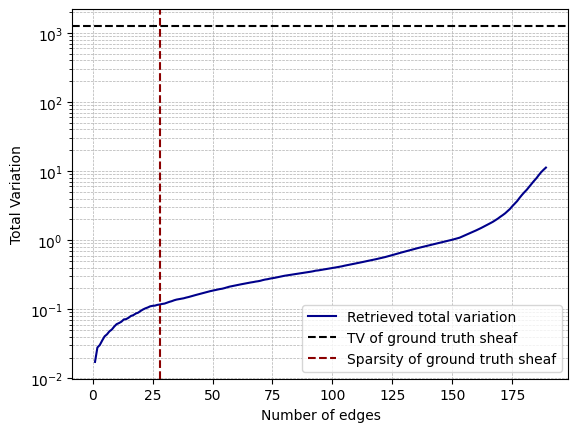

In [37]:
plt.plot(TVs.values(), label='Retrieved total variation', color = 'darkblue')
plt.yscale('log')
plt.xlabel('Number of edges')
plt.ylabel('Total Variation')
plt.axhline(TV, color = 'black', linestyle ='dashed', label = 'TV of ground truth sheaf')
plt.axvline(len(edges), color = 'darkred', linestyle ='dashed', label = 'Sparsity of ground truth sheaf')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [ ]:
# Define optimization variables
M = {}
for i in range(V):
    for j in range(i, V):
        M[(i, j)] = cp.Variable((V*d, V*d), symmetric=True)

# Define L as a new variable and add constraints
L = cp.Variable((V*d, V*d), symmetric=True)
constraints = [L == sum(M[(i, j)] for i in range(V) for j in range(i, V))]

# Ensure positive semi-definiteness and structure of M_ij
for i in range(V):
    for j in range(i, V):
        M_ij = M[(i, j)]
        constraints.append(M_ij >> 0)  # M_ij is positive semi-definite
        if i != j:  # Enforce structural zeros for off-block elements in M_ij
            M_block = M_ij[i*d:(i+1)*d, j*d:(j+1)*d]
            constraints.append(M_block == 0)

# Define penalties
penalty1 = -cp.sum([cp.log(cp.trace(M[(i, i)])) for i in range(V)])
penalty2 = cp.sum([cp.norm(M[(i, j)], 'fro') for i in range(V) for j in range(i + 1, V)])

# Define objective
objective = cp.Minimize(cp.trace(Y.T @ L @ Y) + penalty1 + penalty2)

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver='MOSEK')

# Output results
print("Optimal value:", problem.value)
print("Optimal L:", L.value)

In [38]:
E0

28

In [39]:
retrieved

[((12, 16), 0.11119789946873454),
 ((6, 12), 0.12792161837523),
 ((6, 16), 0.12914318701176775),
 ((14, 16), 0.13165474334450966),
 ((9, 12), 0.13268408771670537),
 ((3, 16), 0.1339269687743985),
 ((12, 13), 0.13568037975997704),
 ((10, 12), 0.13799818188043136),
 ((1, 9), 0.14054063032319716),
 ((2, 9), 0.15323157981612395),
 ((7, 16), 0.15348806294003867),
 ((5, 12), 0.15393436811464714),
 ((0, 3), 0.15567783773735147),
 ((9, 16), 0.16048264310522892),
 ((0, 9), 0.1733170599830472),
 ((1, 12), 0.1770857472920444),
 ((16, 19), 0.17819387844720566),
 ((1, 14), 0.17878904240875615),
 ((3, 12), 0.18189325902862602),
 ((16, 17), 0.18190998505661077),
 ((5, 14), 0.18302419583501459),
 ((0, 5), 0.1841821160394438),
 ((9, 14), 0.187026278248926),
 ((2, 10), 0.18792559107452567),
 ((7, 12), 0.18834398614580808),
 ((1, 16), 0.18939575522512125),
 ((1, 5), 0.19073699187636114),
 ((12, 14), 0.19075409034159158),
 ((3, 5), 0.19309542512001804),
 ((16, 18), 0.19644914959129597),
 ((0, 6), 0.197321

In [21]:
B_hat_2 = np.zeros((d*len(edges), d*V))

for i, edge in enumerate([retrieved[i][0] for i in range(E0)]):

    u = edge[0] 
    v = edge[1] 

    B_u = maps_[edge][u]
    B_v = maps_[edge][v]

    B_hat_2[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
    B_hat_2[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

# Sheaf Laplacian

L_f_hat_2 = B_hat_2.T @ B_hat_2

In [28]:
L_f_hat_2 /= np.linalg.norm(L_f_hat_2)

In [30]:
D = np.diag(np.diagonal(L_f_hat_2))
L_f_hat_2 = fractional_matrix_power(D, -0.5) @ L_f_hat_2 @ fractional_matrix_power(D, -0.5)

In [29]:
np.trace(Y.T @ L_f_hat_2 @ Y)

0.12064387868540732

In [24]:
Z = np.zeros((V,V))

In [25]:
for edge in combinations(range(V),2):
    u = edge[0]
    v = edge[1]

    X_u = Y[u*d:(u+1)*d,:]
    X_v = Y[v*d:(v+1)*d,:]

    Fu = maps_[edge][u]
    Fv = maps_[edge][v]
    Z[u,v] = np.linalg.norm(Fu @ X_u - Fv @ X_v)
    Z[v,u] = np.linalg.norm(Fu @ X_u - Fv @ X_v)

In [26]:
def Kalofolias_Optimization(Z, alpha, beta, n):
    # Define the variable
    W = cp.Variable((n, n), symmetric=True)

    # Constraints: diagonal elements must be zero
    constraints = [cp.diag(W) == 0]

    # Objective function components
    term1 = cp.norm1(cp.multiply(W, Z))  # ||W ∘ Z||_1,1
    term2 = -alpha * cp.sum(cp.log(cp.sum(W, axis=1)))  # -α * 1^T log(W1)
    term3 = (beta / 2) * cp.norm(W, 'fro')**2  # (β/2) * ||W||_F^2

    # Define the objective
    objective = cp.Minimize(term1 + term2 + term3)

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    # Return the optimal solution
    return W.value

In [27]:
alpha = [0.001,0.005,0.01,0.5,1,5]
beta = [0.001,0.005,0.01,0.5,1,5]

for alpha_ in alpha:
    for beta_ in beta:
        W = Kalofolias_Optimization(Z,alpha_, beta_, V)

        for u in range(V):
            for v in range(u,V):
                if W[u,v] < 1e-5:
                    W[u,v] = 0
                    W[v,u] = 0

        retrieved_edges = []

        for u in range(V):
            for v in range(u,V):
                if W[u,v] != 0:
                    retrieved_edges.append((u,v))

        print(alpha_, beta_, len(set(retrieved_edges).intersection(set(edges))) / len(retrieved_edges))

0.001 0.001 0.16666666666666666
0.001 0.005 0.16666666666666666
0.001 0.01 0.16666666666666666
0.001 0.5 0.15789473684210525
0.001 1 0.2
0.001 5 0.25
0.005 0.001 0.16666666666666666
0.005 0.005 0.16666666666666666
0.005 0.01 0.16666666666666666
0.005 0.5 0.22727272727272727
0.005 1 0.25
0.005 5 0.21621621621621623
0.01 0.001 0.16666666666666666
0.01 0.005 0.16666666666666666
0.01 0.01 0.16666666666666666
0.01 0.5 0.25
0.01 1 0.21428571428571427
0.01 5 0.22916666666666666
0.5 0.001 0.15789473684210525
0.5 0.005 0.22727272727272727
0.5 0.01 0.25
0.5 0.5 0.20689655172413793
0.5 1 0.19047619047619047
0.5 5 0.16428571428571428
1 0.001 0.19047619047619047
1 0.005 0.25
1 0.01 0.20689655172413793
1 0.5 0.19047619047619047
1 1 0.19166666666666668
1 5 0.16993464052287582
5 0.001 0.25
5 0.005 0.21052631578947367
5 0.01 0.22916666666666666
5 0.5 0.16428571428571428
5 1 0.16993464052287582
5 5 0.16759776536312848
